# Tracking Depression and Suicidal Ideation in Social Media
### Analysis and Dashboarding for tracking features associated with mental health risk
# Part 4 - Text Classification; Suicidal ideation posts vs other mental health posts with feature extraction
* ## The impact of adding in percentage of absolutist words used per post, sentiment, subjectivity, post length, and time of day posted

### Table of Contents

* <a href='#Part_1'> Abstract</a> 
* <a href='#Part_2'> Obtain & Scrub</a>   
* <a href='#Part_3'> Model Training/Testing</a> 
* <a href='#Part_4'> Hyperparameter Optimization</a>
* <a href='#Part_5'> Final Model</a>
* <a href='#Part_6'> Feature Extraction</a>
* <a href='#Part_7'> Conclusions</a>
* <a href='#Part_8'> Future Work</a>

In [1]:
#Importing Libraries
import requests
import nltk
import json
import time
import pandas as pd
import numpy as np
import re
import praw
import prawcore
import datetime as dt
import matplotlib.pyplot as plt
import scipy
import pymongo
import functions as functions
import os
import patsy as py
import seaborn as sns
import itertools
import xgboost as xgb
import tensorflow
import sklearn
import keras_metrics
import shap
import pickle

from importlib import reload
from numpy import mean, var
from math import sqrt
from os import path
from pymongo import MongoClient, errors
from pymongo.errors import InvalidDocument
from patsy import dmatrices
from textblob import TextBlob

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus.reader.wordnet import ADJ, ADJ_SAT, ADV, NOUN
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn import preprocessing, svm, tree, model_selection
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score,precision_recall_fscore_support, auc
from sklearn.metrics import f1_score, confusion_matrix, make_scorer, classification_report, roc_auc_score, SCORERS
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier                          
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer


from xgboost import XGBClassifier, plot_importance
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gensim.models import Word2Vec
from treeinterpreter import treeinterpreter as ti
from shap import TreeExplainer

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras_metrics import f1_score
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, Input, Dense, LSTM, GRU, Embedding
from keras import optimizers
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, MaxPooling1D
from keras.layers import GlobalMaxPool1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, regularizers, constraints, optimizers, layers

from functions import connect_to_reddit, connect_to_mongo, get_stem_abs, get_stop_words, text_cleaner, get_date;
from functions import submissions_to_mongo, clean_df, get_tot_word, get_abs_word_count, get_perc_abs, cohend;
from functions import get_abs_chart, get_post_distribution, wordcloud, clean_text, get_distribution, get_word_freq;
from functions import evaluate, plot_confusion_matrix, get_authors, get_author_posts, check_exists, mongo_to_df;


os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

reddit connector created
pillosoft connecting to reddit API
mongo connector now created
get stem abs list function created
get lem abs list function created
get stop words function has been created
text cleaner function created
get date function created
submissions to mongo function created
clean df function created
get total word count function created
get absolutist word count created
get percentage of absolutist words function created
get absolitist word count chart function created
get post distribution function created
get word cloud function created
get clean text function created
get perc distribution created
get word frequency function created
Cohens D function created
mongo to df function created
plot confusion matrix function created
evaluate model function created
get authors function created
get author posts function created
check exists function created
date function created


Using TensorFlow backend.


In [2]:
#connecting to mongo database
client = connect_to_mongo()
# connecting to reddit api
reddit = connect_to_reddit()

now connected to mongo
pillosoft connecting to reddit API


<a id='Part_1'></a>

# Abstract
Now that we have a functioning model, it would be helpful if we could extract some features from it. Since neural networks and classifiers don't readily provide us with their inner workings, we are going to have to do a little digging into our classifiers to get some insight.

We are also going to add in some additional features I was able to scrape from reddit, or get on my own. This is where we circle back to absolutist words from the research paper we saw earlier. One feature we are going to add is the percentage of absolutist words used in the post. Another feature we can add is the time of day of the post. Additionally, we can look at sentiment and subjectivity, as well as overall post length. 

Let's see what we can find out!

In [3]:

abs_word_list = ['absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly', 'definitely', 
                 'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 
                 'totally', 'whole']

remove_words = ["http", "https", "www", "com", "reddit", "jpg", 'x', 'b', 'f', 'r', 'c', 'd', 'e', 'f', 
               'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'op', 'q', 's', 't', 'u', 'v', 'w', 'y', 'z',
               '00', '01', '04', '10', '100', '1000', '1000mg', '100mg', '100x', '108', '10k', '10lbs', 
                '10pm', '10th', '10yo', '10yrs', '11', '119', '11am', '11d', '11th', '12', '120', '12g', 
                '12ga', '12ish', '13', '14', '140', '146', '15', '150', '150mg', '1549449839413', '15min', 
                '16', '160', '162', '16f', '16y', '17', '170', '17f', '17th', '17yo', '18', '180', '189', 
                '18months', '18th', '19', '1950', '1974', '1996', '19o', '19th', '1drl', '1k', '1mg', '1st', 
                '1x', '20', '200', '2000', '2003', '2007', '200mg', '2010', '2012', '2014', '2015', '2016', 
                '2017', '2018', '2019', '20mg', '20oz', '20th', '21', '215lbs', '22', '22m', '23', '2300', 
                '23andme', '24', '24hrs', '25', '250', '2500', '250mg', '258', '25mg', '25th', '26', '260lbs', 
                '26yo', '27', '270', '27th', '27year', '28', '28th', '29', '2ahukewiuracn9kbgahvb6kqkhy2ld', 
                '2am', '2l', '2lbs', '2mo', '2nd', '2wks', '2x', '2years', '2yrs', '30', '300', '3000', 
                '3000mg', '300mg', '304', '30th', '31', '310', '31st', '32', '325mg', '32oz', '33', '34', 
                '340', '35', '350', '357', '37', '38', '39', '3am', '3lb', '3mg', '3pm', '3rd', '3rds', '40', 
                '400', '40cl', '40km', '40lbs', '40mg', '40s', '40th', '42', '43m', '44', '45', '450', '48', 
                '48oz', '49', '4am', '4th', '50', '500', '500mg', '50mcg', '50mg', '50oz', '50s', '5150', '5600',
                '5677676', '57', '5k', '5mg', '5pm', '5th', '60', '600', '600mg', '60k', '61', '63', '64', '6am',
                '6mg', '6th', '6yrs', '70', '700', '70cl', '70s', '72', '75mg', '79558b7f', '7pm', '7t4ngdpbitq',
                '7th', '80', '800', '8th', '90', '92', '95', '99', '9am', '9th', '___', '_a', '_anyone', '_be',
                '_food', '_for', '_in', '_interested', '_me', '_tracker', 'aa', 'aans', 'like', 'anxieti', 'depression']

pre_stop_words = list(stopwords.words("english"))

moderators = ['S2S2S2S2S2','Psy-Kosh','SicSemperHumanus','SQLwitch','UnDire','pkbooo','skyqween','MykeeB',
              'circinia','svneko','MuffinMedic','remyschnitzel','vodkalimes','dwade333miami','anxietymods',
              'BotBust','MrZalarox','Pi25','analemmaro', 'abhava-sunya','sofar1776','AccioInternets','palisade2621',
              'Hermiones_Teaspoon','AweBeyCon','dancingonfire','midnightdragon','elbowsss','Chefjones','pezes',
              'sulkee','Greypo','exoendo','Jakeable','MeghanAM','JoyousCacophony','hansjens47','Qu1nlan',
              'english06','samplebitch','optimalg','rhiever','Geographist','frostickle','NonNonHeinous',
              'Vizual-Statistix','sarahbotts','zonination','spermface','yelper','mungoflago','ostedog','rsrsrsrs',
              'townie_immigrant','JoeAllan','theReluctantHipster','AutoModerator', 'iimsorryy','wanderlusterer',
              'awaxa','dosman711','mmccullen','Ariensus','turtletechnology','cascer1','cluckj','adidushi',
              'Muffinzz','IHaveTheBestCandy','crilen','Cerenkov_Blue', 'binarysneaker','vomita_conejitos','polezo']

subreddit_list = ['suicidewatch', 'depression', 'anxiety',
                  'diabetes', 'heartdisease', 'gout', 'copd',
                  'travel', 'basketball', 'harrypotter']

stem_abs = get_stem_abs(abs_word_list)

stop_words = get_stop_words(remove_words, abs_word_list, pre_stop_words)

stop words list length is now:
179
adding words from include list
new words have been added, stop words list length is now:
431
removing exlude words
exclude list words removed. stop words length is now:
430


<a id='Part_2'></a>

# Obtain & Scrub

In [4]:
# accessing collections
reddit_db = client["reddit"]
reddit_submissions = reddit_db['submissions_for_author_analysis']
suicide_redditors = reddit_db['suicide']
dep_redditors = reddit_db['dep']
anx_redditors = reddit_db['anx']
gout_redditors = reddit_db['gout']
db_redditors = reddit_db['db']
copd_redditors = reddit_db['copd']
htn_redditors = reddit_db['htn']
trav_redditors = reddit_db['travel']
bb_redditors = reddit_db['bb']
hp_redditors = reddit_db['hp']

In [5]:
# converting mongo db collections to dataframes
suicide_df, anx_df, dep_df, gout_df, htn_df, copd_df, db_df, travel_df, bb_df, hp_df = (None,)*10
suicide_df = mongo_to_df(suicide_df, suicide_redditors)
anx_df = mongo_to_df(anx_df, anx_redditors)
dep_df = mongo_to_df(dep_df, dep_redditors)
gout_df = mongo_to_df(gout_df, gout_redditors)
htn_df = mongo_to_df(htn_df, htn_redditors)
copd_df = mongo_to_df(copd_df, copd_redditors)
db_df = mongo_to_df(db_df, db_redditors)
travel_df = mongo_to_df(travel_df, trav_redditors)
bb_df = mongo_to_df(bb_df, bb_redditors)
hp_df = mongo_to_df(hp_df, hp_redditors)

In [6]:
# suicide reddit forum authors only, using the same authors' posts over all of reddit:
s_df = suicide_df
s_df.drop_duplicates(subset='cleaned_text', inplace=True)

# anxiety/depression forum authors only, using the same authors' posts over all of reddit:
df = pd.concat([anx_df, dep_df])
df.drop_duplicates(subset='cleaned_text', inplace=True)

# excluding those who are in the anxiety/depression group who have posted in the suicide forum:
df = df[df.subreddit != 'SuicideWatch']

# random sample to even out the groups:
df = df.sample(n=2750)

# labeling the groups 
df['labels'] = 0 # 0: Not suicidal
s_df['labels'] = 1 # 1: Suicidal ideation

# joining the dataframes
final_df = pd.concat([s_df, df])
final_df.drop_duplicates(subset='cleaned_text', inplace=True)
class_names = set(final_df.labels)

## Adding in features calculated from post characteristics:
* ### Time of day - binned to morning, daytime, evening, and overnight
* ### Percentage of Absolutist words used
* ### Post Length
* ### Sentiment
* ### Subjectivity

In [7]:
final_df['time_of_day'] = final_df['hour_posted'].map({0:'overnight',1:'overnight',2:'overnight',3:'overnight',
                                                       4:'overnight',5:'overnight',6:'morning',7:'morning', 
                                                       8:'morning', 9:'morning',10:'daytime', 11:'daytime', 
                                                       12:'daytime', 13:'daytime', 14:'daytime',15:'daytime',
                                                       16:'daytime',17:'evening',18:'evening',19:'evening',
                                                       20:'evening',21:'evening',22:'overnight',23:'overnight',})
cont_features = final_df[["percent_abs_words", "post_length", "sentiment", "subjectivity"]]
cat_features = final_df[["time_of_day"]]
dummies = pd.get_dummies(cat_features, columns=["time_of_day"])

In [8]:
names=cont_features.columns
index = final_df.index
#Scaling all continuous datapoints between 0-5
scaler = preprocessing.MinMaxScaler(feature_range=(0,5))
scaled_df = scaler.fit_transform(cont_features)
cont_features = pd.DataFrame(scaled_df, columns=names, index=index)
cont_features.rename(columns={"sentiment":"_sentiment"}, inplace=True)

In [9]:
X = pd.concat([cont_features, dummies, final_df.cleaned_text], axis=1)
y = final_df.labels

In [10]:
# Count Vectorizing 
matrix = CountVectorizer(max_features=20000)
x = matrix.fit_transform(X.cleaned_text)
df_tr = pd.DataFrame(x.toarray(), columns=matrix.get_feature_names(), index=index)

In [11]:
X = pd.concat([cont_features, dummies, df_tr], axis=1)
class_names = set(y)
y.value_counts()

1    2757
0    2678
Name: labels, dtype: int64

<a id='Part_3'></a>

# Model Training/Testing

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=0.4)

In [14]:
# Multinomial Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier = nb_classifier.fit(X_train, y_train)
nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

In [15]:
# XGBoost Classifier
xgb_classifier = XGBClassifier()
xgb_classifier = xgb_classifier.fit(X_train, y_train)
xgb_train_preds = xgb_classifier.predict(X_train)
xgb_test_preds = xgb_classifier.predict(X_test)

### Results...

Multinomial Naive Bayes

Training Precision:  0.8008497079129049
Testing Precision:  0.6193181818181818



Training Recall:  0.9057057057057057
Testing Recall:  0.6987179487179487



Training Accuracy:  0.8368598589389757
Testing Accuracy:  0.6329346826126955



Training F1 Score:  0.8500563697857948
Testing F1 Score:  0.6566265060240963



Confusion matrix, without normalization


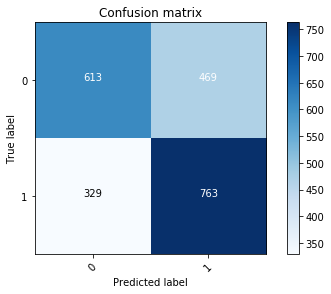




Normalized confusion matrix


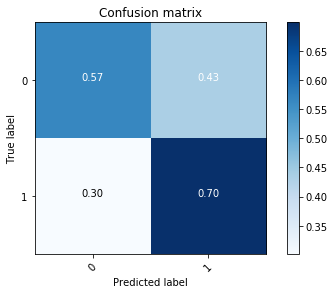

----------------------------------------------------------------------

XGB Classifier

Training Precision:  0.7633175994605529
Testing Precision:  0.6487341772151899



Training Recall:  0.6798798798798799
Testing Recall:  0.5631868131868132



Training Accuracy:  0.728917509966268
Testing Accuracy:  0.6274149034038639



Training F1 Score:  0.7191867852604829
Testing F1 Score:  0.6029411764705882



Confusion matrix, without normalization


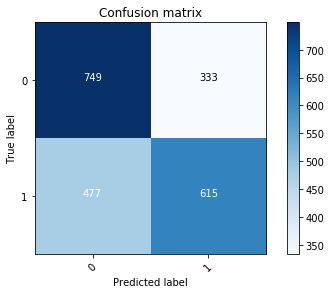




Normalized confusion matrix


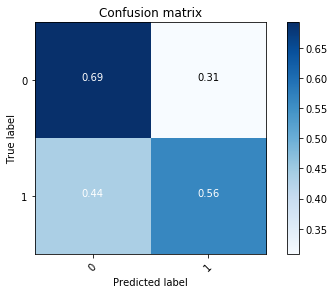

----------------------------------------------------------------------


In [16]:
print("Multinomial Naive Bayes")
print("")
evaluate(y_train, nb_train_preds, y_test, nb_test_preds, class_names=class_names)
print('-'*70)
print("")
print('XGB Classifier')
print("")
evaluate(y_train, xgb_train_preds, y_test, xgb_test_preds, class_names=class_names)
print('-'*70)

<a id='Part_4'></a>

# Hyperparameter Tuning and Optimization

In [17]:
#pipeline to pass to gridsearch
pipe_mnb = Pipeline([('mnb', MultinomialNB())])
#parameters to pass to gridsearch
grid_params = {'mnb__alpha': np.linspace(0.5, 1.5, 3),
               'mnb__fit_prior': [True, False]}

In [19]:
# Utilizing GridSearchCV to scan all parameters and evaluate classifier performance with each parameter passed
gs = GridSearchCV(estimator=pipe_mnb, param_grid=grid_params, scoring='recall', cv=3, verbose=0, return_train_score = True)
gs.fit(X_train, y_train)
print("Best Score: ", gs.best_score_)
print("Best Params: ", gs.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] mnb__alpha=0.5, mnb__fit_prior=True .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. mnb__alpha=0.5, mnb__fit_prior=True, total=   0.8s
[CV] mnb__alpha=0.5, mnb__fit_prior=True .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] .............. mnb__alpha=0.5, mnb__fit_prior=True, total=   0.6s
[CV] mnb__alpha=0.5, mnb__fit_prior=True .............................
[CV] .............. mnb__alpha=0.5, mnb__fit_prior=True, total=   0.6s
[CV] mnb__alpha=0.5, mnb__fit_prior=False ............................
[CV] ............. mnb__alpha=0.5, mnb__fit_prior=False, total=   0.5s
[CV] mnb__alpha=0.5, mnb__fit_prior=False ............................
[CV] ............. mnb__alpha=0.5, mnb__fit_prior=False, total=   0.7s
[CV] mnb__alpha=0.5, mnb__fit_prior=False ............................
[CV] ............. mnb__alpha=0.5, mnb__fit_prior=False, total=   0.6s
[CV] mnb__alpha=1.0, mnb__fit_prior=True .............................
[CV] .............. mnb__alpha=1.0, mnb__fit_prior=True, total=   0.5s
[CV] mnb__alpha=1.0, mnb__fit_prior=True .............................
[CV] .............. mnb__alpha=1.0, mnb__fit_prior=True, total=   0.5s
[CV] mnb__alpha=1.0, mnb__fit_prior=True .............................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   15.8s finished


Best Score:  0.7165165165165165
Best Params:  {'mnb__alpha': 1.5, 'mnb__fit_prior': True}


In [20]:
#implementing above parameters from gridsearch to our pipeline:
nb_classifier = MultinomialNB(alpha=1.5, fit_prior=True)
nb_classifier = nb_classifier.fit(X_train, y_train)
nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

In [23]:
#implementing above parameters from gridsearch to our pipeline:
xgb_classifier = XGBClassifier(learning_rate=0.05, gamma=0.5, scale_pos_weight=1.2)
xgb_classifier = xgb_classifier.fit(X_train, y_train)
xgb_train_preds = xgb_classifier.predict(X_train)
xgb_test_preds = xgb_classifier.predict(X_test)

### Results...

Multinomial Naive Bayes

Training Precision:  0.7894179894179895
Testing Precision:  0.6185483870967742



Training Recall:  0.8960960960960961
Testing Recall:  0.7023809523809523



Training Accuracy:  0.8249003373198406
Testing Accuracy:  0.6329346826126955



Training F1 Score:  0.839381153305204
Testing F1 Score:  0.6578044596912521



Confusion matrix, without normalization


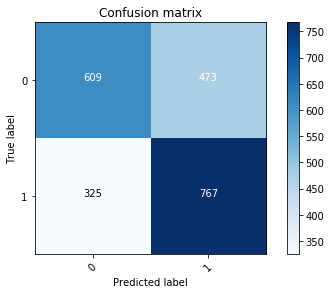




Normalized confusion matrix


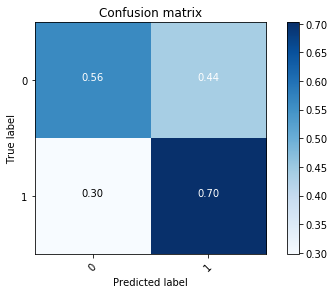

----------------------------------------------------------------------

XGB Classifier

Training Precision:  0.6299447043811144
Testing Precision:  0.5518518518518518



Training Recall:  0.8894894894894895
Testing Recall:  0.8186813186813187



Training Accuracy:  0.6767862618828581
Testing Accuracy:  0.5749770009199632



Training F1 Score:  0.7375498007968128
Testing F1 Score:  0.65929203539823



Confusion matrix, without normalization


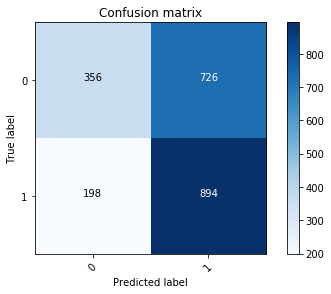




Normalized confusion matrix


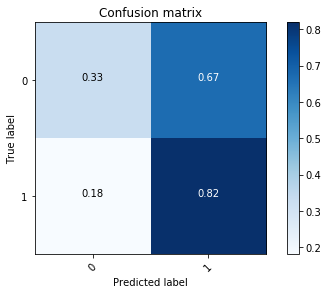

----------------------------------------------------------------------


In [24]:
print("Multinomial Naive Bayes")
print("")
evaluate(y_train, nb_train_preds, y_test, nb_test_preds, class_names=class_names)
print('-'*70)
print("")
print('XGB Classifier')
print("")
evaluate(y_train, xgb_train_preds, y_test, xgb_test_preds, class_names=class_names)
print('-'*70)

It's not perfect but it is pretty impressive considering the raw dataset we are working with and the absence of reliable labels

<a id='Part_5'></a>

# Final Model
### Saving final model to pickle

In [27]:

# Dump the trained decision tree classifier with Pickle
fc_pkl_filename = 'final_classifier.pkl'
# Open the file to save as pkl file
fc_model_pkl = open(fc_pkl_filename, 'wb')
pickle.dump(nb_classifier, fc_model_pkl)
# Close the pickle instances
fc_model_pkl.close()

<a id='Part_6'></a>

## Feature Extraction

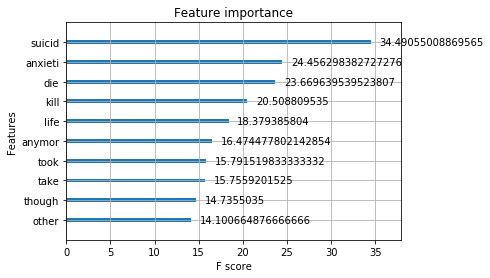

In [33]:
to_plot = plot_importance(xgb_classifier, importance_type='gain', max_num_features=10)
plt.show()
#The Gain is the most relevant attribute to interpret the relative importance of each feature.
#The Gain implies the relative contribution of the corresponding feature to the model calculated by 
#taking each feature’s contribution for each tree in the model. 
#A higher value of this metric when compared to another feature implies it is 
#more important for generating a prediction.

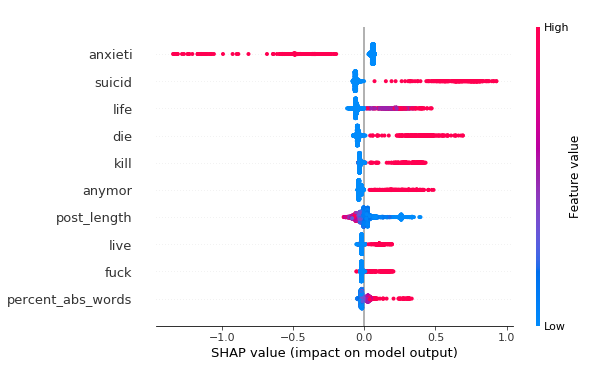

In [34]:
#Using Shap Tree Explainer to show impact of features on model output
shap_vals=shap.TreeExplainer(xgb_classifier).shap_values(X_train)
shap.summary_plot(shap_vals, X_train, max_display=10)

## Important Features
* "anxiety"
* "suicide"
* "life"
* "die"
* "kill"
* "anymore"
* Post Length - shorter contributed to more suicidal posts
* "live"
* "fuck"
* Percentage Absolutist Words used - Higher percentage contributed to more suicidal posts


<a id='Part_7'></a>

# Conclusions

* As suspected, percentage of absolutist words used is a top contributor for determining suicidal ideation posts
* We also leanred that post length is an important feature as well
* Our model is surprisingly effective given the limited scope and reliability of our webscraped dataset
* With access to actual clinical data, this model can improve vastly
* Patients, clinicians and family members stand to benefit from a classification tool that identifies mental health risk such as suicidal ideation

<a id='Part_8'></a>

# Future Work

* Dashboard for clinicians to track progress and monitor patients in real time
* Increased amount of data for better results
* Increased processing ability for faster training and better results
* Additional feature identification for better classification
* Address privacy concerns regarding use of text data for patients